In [36]:
import numpy as np
import random

In [44]:
d = np.load('/content/drive/MyDrive/english_newlit_cbow_3_dict.npy', allow_pickle=True)[()]

In [84]:
random.seed(42)


sample_size = int(len(d) * 0.1)
sampled_items = random.sample(list(d.items()), sample_size)


sampled_arrays = [value for key, value in sampled_items]

combined_array = np.vstack(sampled_arrays)

print(combined_array.shape)

(15305, 3)


In [85]:
combined_array

array([[-1.2848219 , -0.06589904,  0.14557037],
       [-3.5145855 , -2.2151613 , -1.3868814 ],
       [ 0.16985056,  0.20008288, -0.30174527],
       ...,
       [-0.5614343 ,  0.3429857 , -0.05221007],
       [-0.3942477 ,  0.00788156, -0.09638306],
       [ 0.06612644, -0.06966507,  0.2413579 ]], dtype=float32)

In [47]:
import numpy as np
from scipy.spatial import distance_matrix

# Example high-dimensional data
data = combined_array  # 100 points in 50 dimensions

# Compute pairwise distance matrix
dist_matrix = distance_matrix(data, data)


In [48]:
def compute_knn_distances(data, k):
    from sklearn.neighbors import NearestNeighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(data)
    distances, _ = knn.kneighbors(data)
    return distances[:, -1]

k = 5
knn_distances = compute_knn_distances(data, k)
initial_delta = np.mean(knn_distances)
print(f"Initial delta estimate: {initial_delta}")


Initial delta estimate: 0.17140904136070656


In [49]:
import networkx as nx

def construct_rips_vietoris_graph(data, delta):
    dist_matrix = distance_matrix(data, data)
    graph = nx.Graph()
    num_points = data.shape[0]

    for i in range(num_points):
        for j in range(i + 1, num_points):
            if dist_matrix[i, j] <= delta:
                graph.add_edge(i, j)

    return graph

def compute_vertex_degrees(graph):
    return np.array([d for _, d in graph.degree()])

def find_optimal_delta(data, initial_delta, tolerance=0.01, max_iter=100):
    delta = initial_delta
    for _ in range(max_iter):
        graph = construct_rips_vietoris_graph(data, delta)
        degrees = compute_vertex_degrees(graph)

        prop_ge_5 = np.mean(degrees >= 5)
        prop_lt_5 = np.mean(degrees < 5)

        if abs(prop_ge_5 - 0.95) < tolerance and abs(prop_lt_5 - 0.05) < tolerance:
            break

        if prop_ge_5 > 0.95:
            delta *= 0.95  # Decrease delta to reduce connections
        else:
            delta *= 1.05  # Increase delta to add more connections

    return delta, prop_ge_5, prop_lt_5

optimal_delta, prop_ge_5, prop_lt_5 = find_optimal_delta(data, initial_delta)
print(f"Optimal delta: {optimal_delta}")
print(f"Proportion of vertices with degree >= 5: {prop_ge_5}")
print(f"Proportion of vertices with degree < 5: {prop_lt_5}")

Optimal delta: 0.5264869425185089
Proportion of vertices with degree >= 5: 0.948959032907992
Proportion of vertices with degree < 5: 0.05104096709200806


In [86]:
G = construct_rips_vietoris_graph(combined_array, 0.5264869425185089)

In [87]:
import matplotlib.pyplot as plt

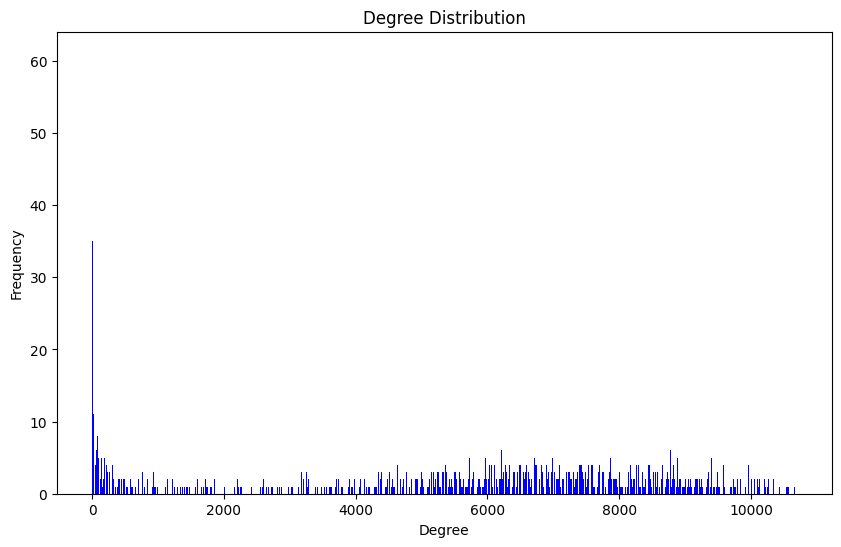

In [88]:
degrees = [degree for node, degree in G.degree()]


degree_counts = {}
for degree in degrees:
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1


degree_values = list(degree_counts.keys())
degree_frequencies = list(degree_counts.values())


plt.figure(figsize=(10, 6))
plt.bar(degree_values, degree_frequencies, width=0.8, color='b')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

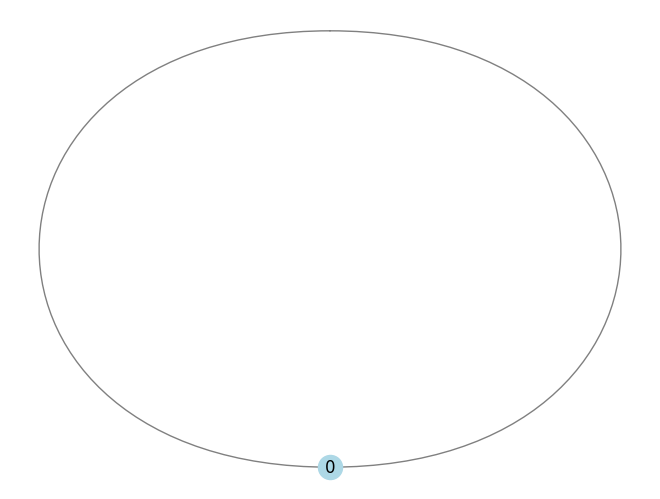

In [20]:
import numpy as np
import networkx as nx
from scipy.spatial import KDTree

def compute_rips_vietoris_graph(points, r):
    tree = KDTree(points)
    edges = tree.query_pairs(r)
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

def label_points(Y, d_Y, r):
    edge_points = []
    branch_points = []

    tree = KDTree(Y)
    for i, y in enumerate(Y):
        shell_indices = tree.query_ball_point(y, 5 * r / 3)
        shell_indices = [idx for idx in shell_indices if d_Y[i, idx] >= r]
        shell_points = Y[shell_indices]

        if len(shell_points) < 2:
            branch_points.append(i)
            continue

        shell_graph = compute_rips_vietoris_graph(shell_points, 4 * r / 3)
        if nx.number_connected_components(shell_graph) == 2:
            edge_points.append(i)
        else:
            branch_points.append(i)

    return edge_points, branch_points

def expand_branch_points(Y, branch_points, r):
    tree = KDTree(Y)
    expanded_branch_points = set(branch_points)

    for idx in branch_points:
        neighbors = tree.query_ball_point(Y[idx], 2 * r)
        expanded_branch_points.update(neighbors)

    return list(expanded_branch_points)

def reconstruct_graph(Y, edge_points, branch_points, r):
    E = Y[edge_points]
    V = Y[branch_points]

    edge_graph = compute_rips_vietoris_graph(E, 2 * r)
    branch_graph = compute_rips_vietoris_graph(V, 2 * r)

    components_E = list(nx.connected_components(edge_graph))
    components_V = list(nx.connected_components(branch_graph))

    G = nx.Graph()
    G.add_nodes_from(range(len(components_V)))

    component_map_E = {v: i for i, component in enumerate(components_E) for v in component}
    component_map_V = {v: i for i, component in enumerate(components_V) for v in component}

    for i, component_V in enumerate(components_V):
        for j, component_E in enumerate(components_E):
            if any(d_Y[v, e] < 2 * r for v in component_V for e in component_E):
                G.add_edge(i, j)

    return G

def assign_edge_lengths(G, Y, edge_points, r):
    E = Y[edge_points]
    edge_graph = compute_rips_vietoris_graph(E, 2 * r)
    components_E = list(nx.connected_components(edge_graph))

    for i, j in G.edges():
        component_E = components_E[j]
        component_points = E[list(component_E)]
        diameter = np.max(np.linalg.norm(component_points[:, None] - component_points, axis=2))
        G.edges[i, j]['length'] = diameter + 4 * r

def metric_graph_reconstruction(Y, d_Y, r):
    edge_points, branch_points = label_points(Y, d_Y, r)
    branch_points = expand_branch_points(Y, branch_points, r)

    G = reconstruct_graph(Y, edge_points, branch_points, r)
    assign_edge_lengths(G, Y, edge_points, r)

    return G

# Example usage
Y = np.random.rand(100, 2)  # Replace with your dataset
d_Y = np.linalg.norm(Y[:, None] - Y, axis=2)  # Distance matrix for Y
r = 0.1  # Choose an appropriate r based on your data

G = metric_graph_reconstruction(Y, d_Y, r)

# To visualize the graph (optional, requires matplotlib)
import matplotlib.pyplot as plt

pos = {i: np.mean(Y[list(component)], axis=0) for i, component in enumerate(nx.connected_components(compute_rips_vietoris_graph(Y, r)))}
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()


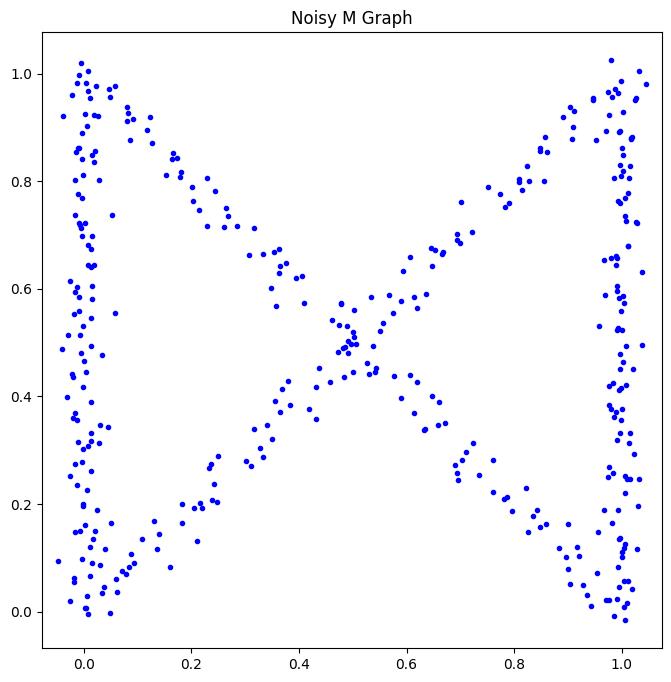

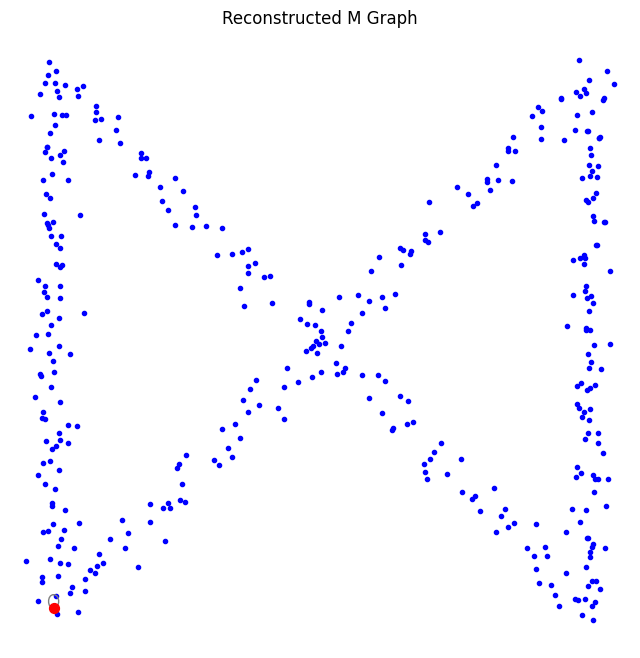

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def generate_noisy_M_graph(noise_level=0.05, num_points_per_segment=100):
    # Define the base points of the "M"
    points = []

    # Left vertical line
    for i in np.linspace(0, 1, num_points_per_segment):
        points.append([0, i])

    # Left diagonal line
    for i in np.linspace(0, 1, num_points_per_segment):
        points.append([i, 1 - i])

    # Right diagonal line
    for i in np.linspace(0, 1, num_points_per_segment):
        points.append([1 - i, 1 - i])

    # Right vertical line
    for i in np.linspace(0, 1, num_points_per_segment):
        points.append([1, i])

    points = np.array(points)

    # Add noise
    noise = noise_level * np.random.randn(*points.shape)
    noisy_points = points + noise

    return noisy_points

# Generate noisy "M" graph
Y = generate_noisy_M_graph(noise_level=0.02, num_points_per_segment=100)
d_Y = np.linalg.norm(Y[:, None] - Y, axis=2)

# Visualization function
def plot_graph(Y, G=None, title='Graph'):
    plt.figure(figsize=(8, 8))
    plt.scatter(Y[:, 0], Y[:, 1], c='blue', marker='.')

    if G:
        pos = {i: Y[i] for i in range(len(Y))}
        nx.draw(G, pos, node_color='red', edge_color='gray', with_labels=False, node_size=50)

    plt.title(title)
    plt.axis('equal')
    plt.show()

# Plot the original noisy "M" graph
plot_graph(Y, title='Noisy M Graph')

# Assuming metric_graph_reconstruction is already implemented and imported
r = 0.3 # Choose an appropriate r based on the graph's scale
G_reconstructed = metric_graph_reconstruction(Y, d_Y, r)

# Plot the reconstructed graph
plot_graph(Y, G_reconstructed, title='Reconstructed M Graph')


In [36]:
d_Y

array([[0.        , 0.00821796, 0.02892267, ..., 1.39013421, 1.37338982,
        1.42565534],
       [0.00821796, 0.        , 0.02087502, ..., 1.39352578, 1.37695229,
        1.42898269],
       [0.02892267, 0.02087502, 0.        , ..., 1.39756819, 1.38146478,
        1.43284496],
       ...,
       [1.39013421, 1.39352578, 1.39756819, ..., 0.        , 0.03585758,
        0.03748496],
       [1.37338982, 1.37695229, 1.38146478, ..., 0.03585758, 0.        ,
        0.06832743],
       [1.42565534, 1.42898269, 1.43284496, ..., 0.03748496, 0.06832743,
        0.        ]])

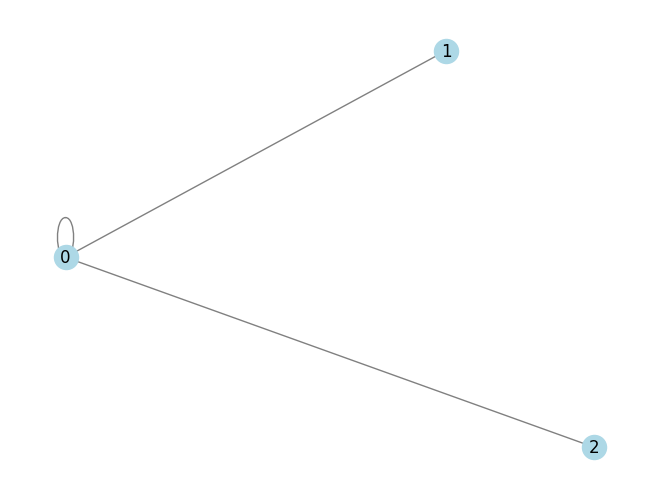

In [39]:
pos = {i: np.mean(Y[list(component)], axis=0) for i, component in enumerate(nx.connected_components(compute_rips_vietoris_graph(Y, r)))}
nx.draw(G_reconstructed, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

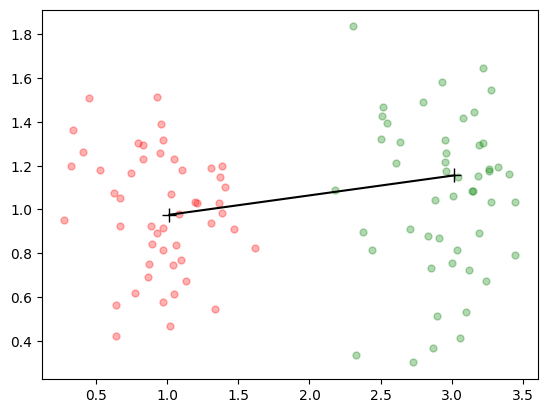

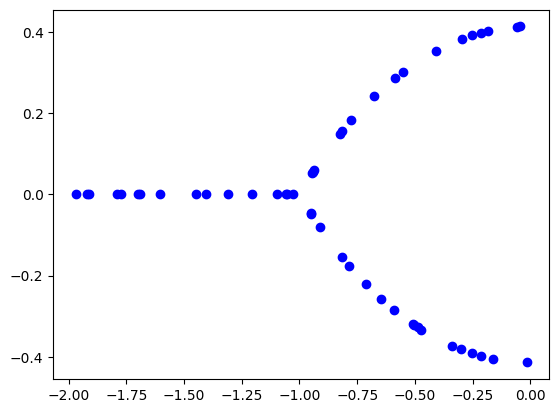

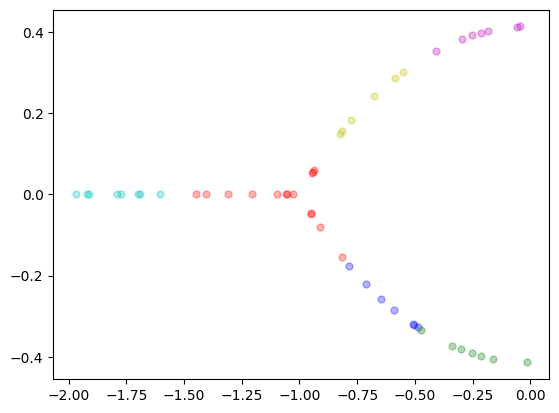

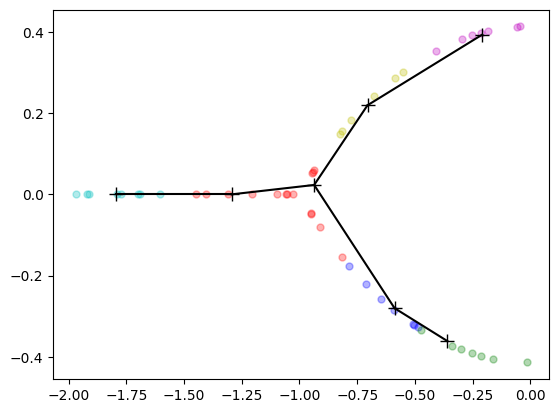

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift
from sklearn.neighbors import KernelDensity
from sklearn.cluster import estimate_bandwidth

def save_data(name, data):
    path = "./data/" + name + ".xy"
    np.savetxt(path, data)

def load_data(name):
    path = "./data/" + name + ".xy"
    data = np.loadtxt(path)
    return data

def simulate_data():
    n_samples = 100
    modes_sim = [(1,1), (3,1)]
    k_sim = len(modes_sim)
    data, labels_sim = make_blobs(n_samples=n_samples,
                                  centers=modes_sim,
                                  n_features=k_sim,
                                  center_box=(0, 1),
                                  cluster_std = 0.30)
    save_data("test_data", data)
    save_data("test_labels", labels_sim)

def visualize(data):
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, c="blue")
    plt.show()

def visualize_sim(data, labels):
    colors = 10*['r.','g.', 'b.', 'c.','m.','y.']
    for i in range(data.shape[0]):
        plt.plot(data[i][0], data[i][1],
                 colors[labels[i]], markersize=10, alpha=0.3)
    plt.show()

def normalize(data):
    d_min = np.min(data, axis=0)
    d_max = np.max(data, axis=0)
    data_n = (data - d_min) / (d_max - d_min)
    return data_n

def prepare_grid(a, b, c, d, n=100):
    x = np.linspace(a, b, n)
    y = np.linspace(c, d, n)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    return X, Y, xy

def kernel_bandwidth(data):
    """ Normal reference rule with a slight modification of Chacon et al. (2011).
    TODO: on small data set via grid search cross-validation to balance bias-variance
    """
    d = data.shape[1]
    n = data.shape[0]
    s = 1/d * np.sum(np.std(data, axis=0))
    h = s * (4 / (d + 4))**(1/(d + 6)) * n**(-1/(d + 6))
    return h

def kernel_bandwidth_sklearn(data, quantile=0.3, n_samples=None):
    """ TODO: try elbow method by increasing quantile to determine the number of modes. """
    return estimate_bandwidth(data, quantile=quantile, n_samples=n_samples)

def evaluate_density_sklearn(xy, data, h):
    """ TODO: increase n_jobs to speed it up. """
    kde = KernelDensity(bandwidth=h, kernel='gaussian')
    kde.fit(data)
    Z = np.exp(kde.score_samples(xy))
    return Z

def kernel(x):
    return np.exp(-x**2 / 2.)

def distance(x, y):
    return np.linalg.norm(x - y)

def soft_assignment(data, modes, h):
    n = data.shape[0]
    k = modes.shape[0]

    S = np.zeros((n, k))
    T = np.zeros((n, n))
    for i in range(n):
        nrmc = np.sum(kernel(np.linalg.norm(data[i] - data, axis=1)/h))
        nrmc += np.sum(kernel(np.linalg.norm(data[i] - modes, axis=1)/h))
        S[i, :] = kernel(np.linalg.norm(data[i] - modes, axis=1)/h)/nrmc
        T[i, :] = kernel(np.linalg.norm(data[i] - data, axis=1)/h)/nrmc
        #assert np.sum(S[i, :]) + np.sum(T[i, :]) - 1.0 < tol, "Normalization constant != 1"

    # soft assignment matrix A
    A = np.linalg.pinv(np.identity(n) - T) @ S
    # for given labels from significant clusters it has to hold:
    #assert sum([(np.argmax(A[i, :]) == labels[i]) for i in range(n)]) == n, "Soft assignment failed!"

    return A

def connectivity(A, labels, i, j):
    indices = np.where(labels == i)[0]
    sum_i = np.sum(A[indices, j]) / len(indices)

    indices = np.where(labels == j)[0]
    sum_j = np.sum(A[indices, i]) / len(indices)

    return (sum_i + sum_j)/2

def denoising_threshold(data):
    ''' Remove modes with clusters sizes < n_0. '''
    n = data.shape[0]
    d = data.shape[1]
    n_0 = (n*np.log(n)/20)**(d/(d + 6))
    return n_0

def connectivity_threshold(modes):
    return 1 / (2 * len(modes))

def reconstruct(data, h=None, n=None, c=None):
    ## mode seeking
    if h != None:
        h_0 = h
    else:
        h_0 = kernel_bandwidth(data)
    ms = MeanShift(bandwidth=h_0).fit(data)
    labels = ms.labels_
    modes = ms.cluster_centers_
    k = len(np.unique(labels))

    ## denoising to reduce the number of local modes by thresholding the cluster sizes
    n_0 = 1 / (2 * k)
    sizes = np.array([np.sum(labels == i) for i in range(k)])
    indices = np.where(sizes > n_0)[0]
    k_0 = len(indices)

    ## graph reconstruction by soft cluster assignment and connectivity metric
    A = soft_assignment(data, modes, h_0)
    c_0 = np.mean(A.flatten())
    G = np.zeros((k_0, k_0))
    if n != None:
        n_0 = n
    if c != None:
        c_0 = c
    for i in range(k_0 - 1):
        for j in range(i + 1, k_0):
            label_i = indices[i]
            label_j = indices[j]
            if connectivity(A, labels, label_i, label_j) > c_0:
                G[i, j] = 1
    return labels, modes, indices, G

def visualize_graph(data, labels, modes, indices, G):
    k = len(indices)
    colors = 10*['r.','g.', 'b.', 'c.','m.','y.']

    for i in range(data.shape[0]):
        plt.plot(data[i][0], data[i][1],
                 colors[labels[i]], markersize=10, alpha=0.3)

    for i in range(k):
        label_i = indices[i]
        plt.plot(modes[label_i, 0], modes[label_i, 1],
                 marker='+', color='k', markersize=10)

    for i in range(k - 1):
        for j in range(i + 1, k):
            if G[i, j] == 1:
                label_i = indices[i]
                label_j = indices[j]
                x1, y1 = modes[label_i]
                x2, y2 = modes[label_j]
                plt.plot([x1, x2], [y1, y2], color='k')
    plt.show()

def simple_test():
    # simulate_data()
    data = load_data("test_data")
    labels_sim = load_data("test_labels")

    h_0 = kernel_bandwidth_sklearn(data)
    ms = MeanShift(bandwidth=h_0).fit(data)
    labels = ms.labels_
    modes = ms.cluster_centers_
    k = len(np.unique(labels))
    labels_sim = [int(lab) for lab in labels]
    # visualize_sim(data, labels_sim)

    n_0 = denoising_threshold(data)
    c_0 = connectivity_threshold(modes)
    labels, modes, indices, G = reconstruct(data, h=h_0, n=n_0, c=c_0)
    visualize_graph(data, labels, modes, indices, G)

def claw_test():
    data = load_data("claw/claw_dense_sample")
    visualize(data)

    h = kernel_bandwidth(data)
    ms = MeanShift(bandwidth=h).fit(data)
    labels = ms.labels_
    modes = ms.cluster_centers_
    k = len(np.unique(labels))
    labels_sim = [int(lab) for lab in labels]
    visualize_sim(data, labels_sim)

    labels, modes, indices, G = reconstruct(data)
    visualize_graph(data, labels, modes, indices, G)

if __name__ == "__main__":
    simple_test()
    claw_test()

Preliminary Labels: ['edge', 'edge', 'edge', 'edge', 'edge', 'preliminary_branch', 'edge', 'preliminary_branch', 'preliminary_branch', 'edge', 'edge', 'edge', 'edge', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'edge', 'edge', 'preliminary_branch', 'edge', 'preliminary_branch', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'preliminary_branch', 'edge', 'preliminary_branch', 'preliminary_branch', 'edge', 'edge', 'preliminary_branch', 'edge', 'edge', 'edge', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'preliminary_branch', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'edge', 'preliminary_branch', 'edge', 'edge', 'preliminary_branch', 'edge', 'edge', 'preliminary_branch', 'edge', 'preliminary_branch', 'edge', 'preliminary_branch', 'preliminary_bran

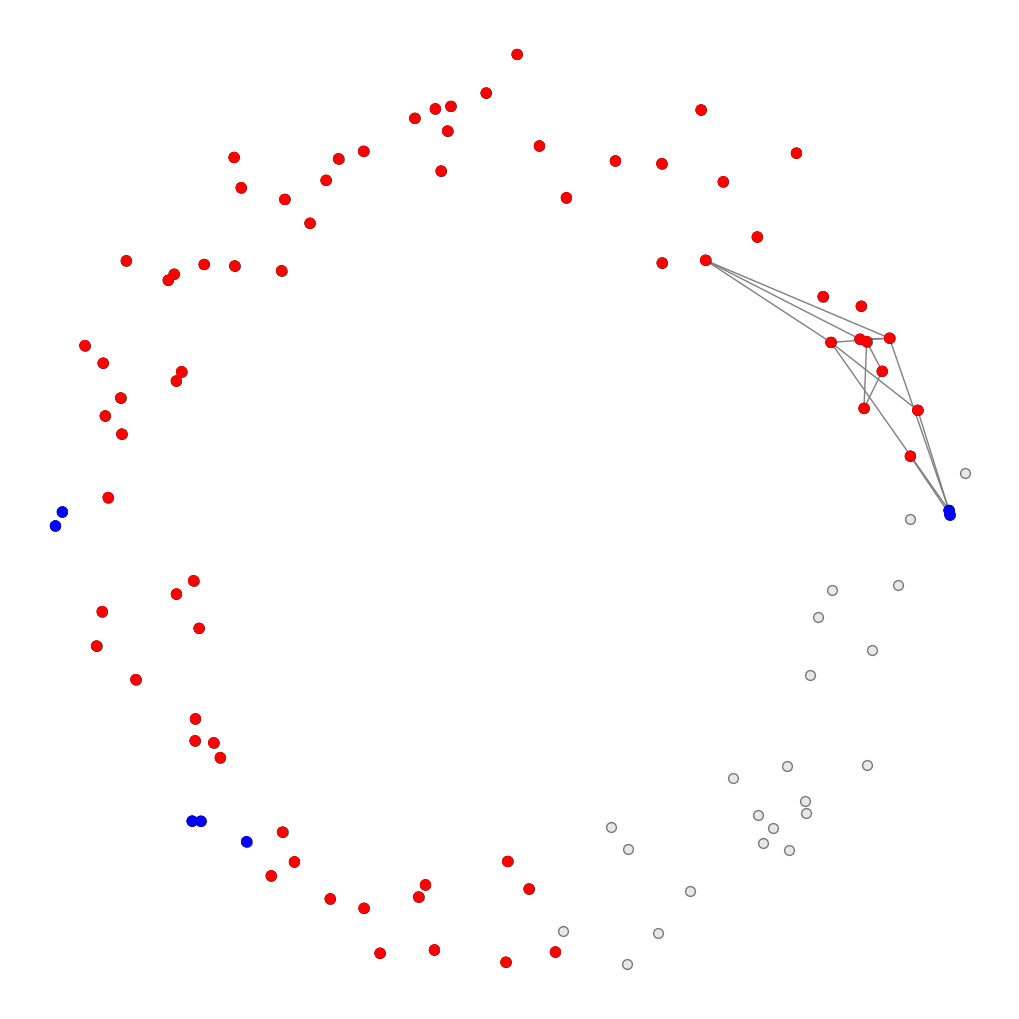

In [78]:
import numpy as np
import networkx as nx
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

def rips_vietoris_graph(points, r):
    tree = KDTree(points)
    edges = list(tree.query_pairs(r))
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    G.add_edges_from(edges)
    return G

def metric_graph_reconstruction(Y, dY, r):
    def label_points(Y, r):
        labels = ['unknown'] * len(Y)
        for i, y in enumerate(Y):
            Sy_indices = [j for j in range(len(Y)) if r < dY[i][j] < 5*r/3]
            if len(Sy_indices) > 0:
                Sy = Y[Sy_indices]
                G = rips_vietoris_graph(Sy, 4*r/3)
                degr_y = nx.number_connected_components(G)
                if degr_y == 2:
                    labels[i] = 'edge'
                else:
                    labels[i] = 'preliminary_branch'

        print("Preliminary Labels:", labels)  # Debug statement

        for i, label in enumerate(labels):
            if label == 'preliminary_branch':
                for j in range(len(Y)):
                    if dY[i][j] < 2*r:
                        labels[j] = 'branch'

        print("Final Labels:", labels)  # Debug statement
        return labels

    def reconstruct_graph_structure(Y, labels, r):
        E = [i for i, label in enumerate(labels) if label == 'edge']
        V = [i for i, label in enumerate(labels) if label == 'branch']

        print("Edge Points:", E)  # Debug statement
        print("Branch Points:", V)  # Debug statement

        GE = rips_vietoris_graph(Y[E], 2*r)
        GV = rips_vietoris_graph(Y[V], 2*r)
        X_hat = nx.Graph()
        X_hat.add_nodes_from(GV.nodes())
        for v1, v2 in GV.edges():
            if v1 in GE and v2 in GE and nx.has_path(GE, source=v1, target=v2):
                X_hat.add_edge(v1, v2)

        print("Reconstructed Graph Nodes:", X_hat.nodes())
        print("Reconstructed Graph Edges:", X_hat.edges())

        return X_hat

    labels = label_points(Y, r)
    X_hat = reconstruct_graph_structure(Y, labels, r)
    return X_hat, labels

def compute_distance_matrix(points):
    tree = KDTree(points)
    dist_matrix = tree.sparse_distance_matrix(tree, np.inf).toarray()
    np.fill_diagonal(dist_matrix, np.inf)  # Ensure self-distances are effectively infinite
    return dist_matrix

# Generate synthetic data with noise
def generate_synthetic_data():
    np.random.seed(0)
    t = np.linspace(0, 2 * np.pi, 100)
    x = np.cos(t)
    y = np.sin(t)
    circle_points = np.vstack((x, y)).T
    noise = np.random.normal(0, 0.1, circle_points.shape)
    noisy_circle_points = circle_points + noise
    return noisy_circle_points

def visualize_graph(points, graph, labels):
    plt.figure(figsize=(10, 10))
    pos = {i: points[i] for i in graph.nodes}
    node_colors = ['blue' if labels[i] == 'edge' else 'red' for i in graph.nodes]

    nx.draw(graph, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color='gray')
    plt.scatter(points[:, 0], points[:, 1], c='lightgray', s=50, edgecolors='k', alpha=0.5)
    plt.scatter([points[i, 0] for i in graph.nodes], [points[i, 1] for i in graph.nodes], c=node_colors, s=50, edgecolors='k')
    plt.show()

# Main execution
Y = generate_synthetic_data()
dY = compute_distance_matrix(Y)
r = 0.2  # Adjusted radius to ensure it is appropriate for the data scale
X_hat, labels = metric_graph_reconstruction(Y, dY, r)
visualize_graph(Y, X_hat, labels)


Preliminary Labels: ['preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'edge', 'preliminary_branch', 'edge', 'edge', 'preliminary_branch', 'edge', 'preliminary_branch', 'edge', 'edge', 'edge', 'preliminary_branch', 'preliminary_branch', 'edge', 'preliminary_branch', 'edge', 'edge', 'edge', 'preliminary_branch', 'preliminary_branch', 'edge', 'preliminary_branch', 'edge', 'preliminary_branch', 'edge', 'edge', 'edge', 'preliminary_branch', 'edge', 'preliminary_branch', 'edge', 'edge', 'edge', 'unknown', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'edge', 'edge', 'edge', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'edge', 'unknown', 'edge', 'edge', 'edge', 'preliminary_branch', 'unknown', 'preliminary_branch', 'edge', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'preliminary_branch', 'edge', 'preliminary_branch', 'edge', 'p

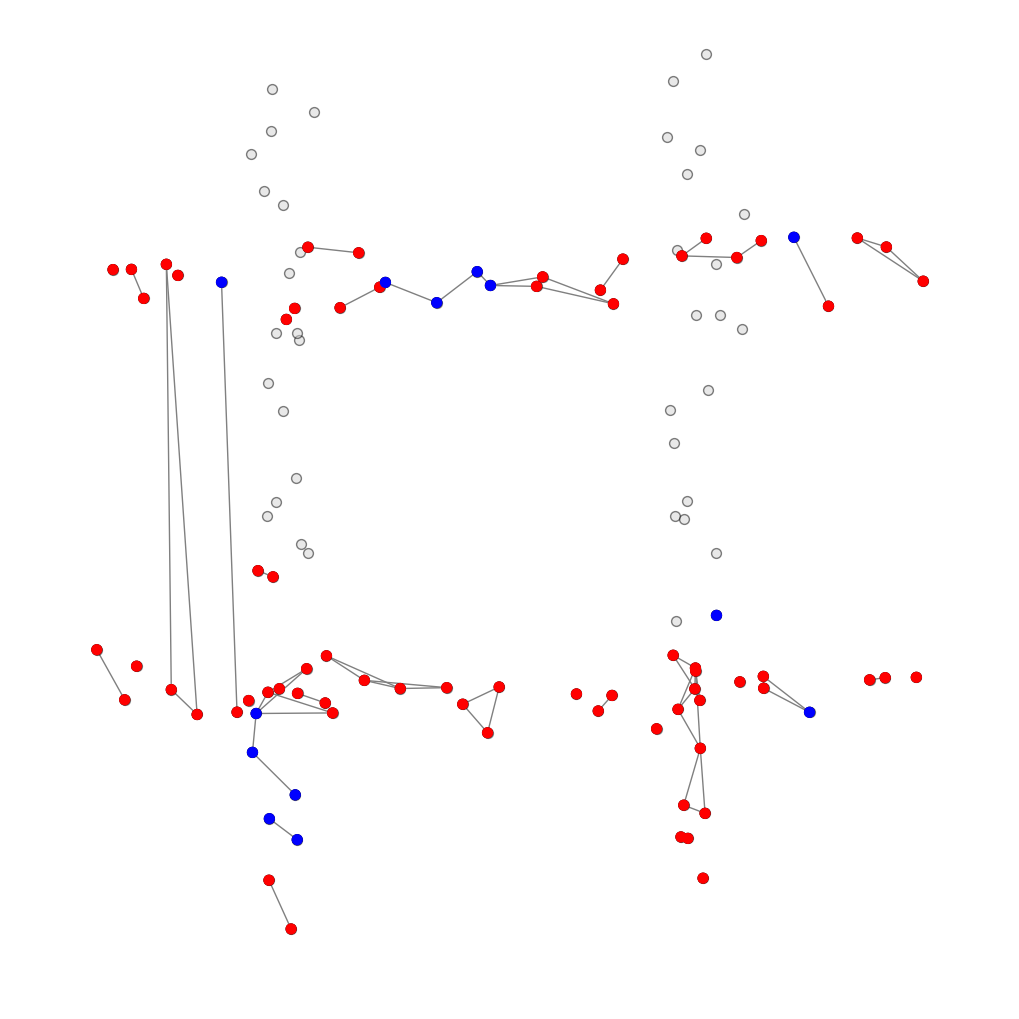

In [97]:
import numpy as np
import networkx as nx
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

def rips_vietoris_graph(points, r):
    tree = KDTree(points)
    edges = list(tree.query_pairs(r))
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    G.add_edges_from(edges)
    return G

def metric_graph_reconstruction(Y, dY, r):
    def label_points(Y, r):
        labels = ['unknown'] * len(Y)
        for i, y in enumerate(Y):
            Sy_indices = [j for j in range(len(Y)) if r < dY[i][j] < 5*r/3]
            if len(Sy_indices) > 0:
                Sy = Y[Sy_indices]
                G = rips_vietoris_graph(Sy, 4*r/3)
                degr_y = nx.number_connected_components(G)
                if degr_y == 2:
                    labels[i] = 'edge'
                else:
                    labels[i] = 'preliminary_branch'

        print("Preliminary Labels:", labels)  # Debug statement

        for i, label in enumerate(labels):
            if label == 'preliminary_branch':
                for j in range(len(Y)):
                    if dY[i][j] < 2*r:
                        labels[j] = 'branch'

        print("Final Labels:", labels)  # Debug statement
        return labels

    def reconstruct_graph_structure(Y, labels, r):
        E = [i for i, label in enumerate(labels) if label == 'edge']
        V = [i for i, label in enumerate(labels) if label == 'branch']

        print("Edge Points:", E)  # Debug statement
        print("Branch Points:", V)  # Debug statement

        GE = rips_vietoris_graph(Y[E], 2*r)
        GV = rips_vietoris_graph(Y[V], 2*r)
        X_hat = nx.Graph()
        X_hat.add_nodes_from(GV.nodes())
        for v1, v2 in GV.edges():
            if v1 in GE and v2 in GE:
                if nx.has_path(GE, source=v1, target=v2):
                    X_hat.add_edge(v1, v2)
            elif dY[v1][v2] < 2*r:  # Ensure that nodes are within a reasonable distance
                X_hat.add_edge(v1, v2)

        print("Reconstructed Graph Nodes:", X_hat.nodes())
        print("Reconstructed Graph Edges:", X_hat.edges())

        return X_hat

    labels = label_points(Y, r)
    X_hat = reconstruct_graph_structure(Y, labels, r)
    return X_hat, labels

def compute_distance_matrix(points):
    tree = KDTree(points)
    dist_matrix = tree.sparse_distance_matrix(tree, np.inf).toarray()
    np.fill_diagonal(dist_matrix, np.inf)  # Ensure self-distances are effectively infinite
    return dist_matrix

# Generate synthetic "#" shape data with noise
def generate_hash_shape_data():
    np.random.seed(0)
    points = []

    # Horizontal lines of the "#"
    for x in np.linspace(-1, 1, 30):
        points.append([x, 0.5])
        points.append([x, -0.5])

    # Vertical lines of the "#"
    for y in np.linspace(-1, 1, 30):
        points.append([-0.5, y])
        points.append([0.5, y])

    points = np.array(points)
    noise = np.random.normal(0, 0.05, points.shape)
    noisy_hash_points = points + noise
    return noisy_hash_points

def visualize_graph(points, graph, labels):
    plt.figure(figsize=(10, 10))
    pos = {i: points[i] for i in graph.nodes}
    node_colors = ['blue' if labels[i] == 'edge' else 'red' for i in graph.nodes]

    nx.draw(graph, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color='gray')
    plt.scatter(points[:, 0], points[:, 1], c='lightgray', s=50, edgecolors='k', alpha=0.5)
    plt.scatter([points[i, 0] for i in graph.nodes], [points[i, 1] for i in graph.nodes], c=node_colors, s=50, edgecolors='k')
    plt.show()

# Main execution
Y = generate_hash_shape_data()
dY = compute_distance_matrix(Y)
r = 0.1  # Adjusted radius to ensure it is appropriate for the data scale
X_hat, labels = metric_graph_reconstruction(Y, dY, r)
visualize_graph(Y, X_hat, labels)
